This notebook is heavily based on the BWR example from https://nbviewer.org/github/mit-crpg/openmc-reactor-examples/blob/main/BWR.ipynb

In [102]:
%matplotlib inline
import openmc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import openmc.deplete

depletion_chain = '/home/arnau/documents/code/openmv-dev/chain_endfb71_pwr.xml'

fs = 15

# Material

## Zircaloy, steel, helium, and water

In [103]:
# Materials definitions

# Zr2 composition as described in https://www.matweb.com/search/datasheet_print.aspx?matguid=eb1dad5ce1ad4a1f9e92f86d5b44740d
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.57)
zircaloy.add_element('Zr', 98.5, percent_type='wo')
zircaloy.add_element('Sn', 1.4, percent_type='wo')
zircaloy.add_element('O', 0.12, percent_type='wo')
zircaloy.add_element('Ni', 0.05, percent_type='wo')
zircaloy.add_element('Fe', 0.1, percent_type='wo')
zircaloy.add_element('Cr', 0.1, percent_type='wo')

# Helium for cladding gap.
helium = openmc.Material(name='Helium')
helium.add_element('He', 1)
helium.set_density('g/cm3', 0.178)  # Room temp density.

# Water
water = openmc.Material(name='Water')
water.set_density('g/cm3', 0.997)  # Room temperature water density.
water.add_element('H', 2)
water.add_element('O', 1)
water.add_s_alpha_beta('c_H_in_H2O')

# R2

## 64 different materials for rods

In [104]:
water_idxs = [0, 4, 21, 27, 32, 42, 44]  # R2

# Test water-rod placement
for i in range(8):
    print([1 if not (i*8+j in water_idxs) else 2 for j in range(8)])

[2, 1, 1, 1, 2, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 2, 1, 1]
[1, 1, 1, 2, 1, 1, 1, 1]
[2, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 2, 1, 2, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1]


In [105]:
# This should be changed to read the 64 rod materials from CASMO. In this example it's just fresh UO2 fuel.
def get_fuel_material():
    '''
    IC is a dataframe that contains a column for each pin, and a row for each isotopes.
    Each cell contains the weight percent of that element in this pin.
    Furthermore, it contains an extra column in front with isotope names e.g. U235
    and an extra row at the bottom with the material density in g/cm3.
    i is the fuel-pin index, an int in [0,63]
    '''
    
    if i in water_idxs:
        print("You have given me en i=", i, "that is a water rod.")
        return 0
            
    local_mat = openmc.Material(name='fuel material number' + str(i))
    local_mat.set_density('g/cm3', 10.205)  # Fresh fuel density, from my CASMO file.
    local_mat.add_element('U', 1.0, enrichment=3.095)
    local_mat.add_element('O', 2.0)
    
    # Adding volume is necessary for depletion calculations.
    # Every pin_cell has same volume
    local_mat.volume = np.pi * 0.4645**2  # In cm2.
    
    return local_mat

materials = [get_fuel_material() if not (i in water_idxs) else "water" for i in range(64)]  # 57 rods + 7 water rods.
fuel_materials = [mat for mat in materials if mat != "water" ]

## Materials file

In [106]:
# Instantiate a Materials collection and export to xml. (water only needs to be instantiated once)
materials_file = openmc.Materials(fuel_materials +
                                  [zircaloy, helium, water])
materials_file.export_to_xml()

### Colours for plots:

In [107]:
color_dict = {water: "aqua", zircaloy: "grey", helium: "cyan", steel: "black"}
color_dict.update({mat: "orange" for mat in fuel_materials})

## Geometry

In [108]:
# Geometry definitions

In [109]:
pitch = 1.43
pin_cell_box = openmc.rectangular_prism(width=pitch, height=pitch)

## Water rods

In [110]:
# Geometry definitions for the water rod

water_or = openmc.ZCylinder(r=0.6505)
wclad_or = openmc.ZCylinder(r=0.6935)

wwater_inner_region = -water_or
wclad_region = -wclad_or & +water_or 
wwater_outer_region = pin_cell_box & +wclad_or

wwater_inner_cell = openmc.Cell(name='wwater_inner')
wwater_inner_cell.region = wwater_inner_region
wwater_inner_cell.fill = water

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

wwater_outer_cell = openmc.Cell(name='wwater_outer')
wwater_outer_cell.fill = water
wwater_outer_cell.region = wwater_outer_region

water_pin_universe = openmc.Universe(cells=[wwater_inner_cell, wclad_cell, wwater_outer_cell])

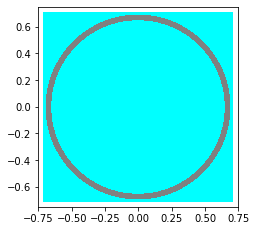

In [111]:
water_pin_universe.plot(width=(1.5, 1.5), color_by = "material", 
                           colors = color_dict)

## 64 different fuel rods

In [112]:
def get_fuel_universe(material):
    fuel_or  = openmc.ZCylinder(r=0.4645, name='Fuel OR')
    fclad_ir = openmc.ZCylinder(r=0.4742, name='Clad IR')
    fclad_or = openmc.ZCylinder(r=0.5360, name='Clad OR')

    fuel_region = -fuel_or 
    gap_region  = +fuel_or & -fclad_ir
    fclad_region  = +fclad_ir & -fclad_or
    fwater_region = pin_cell_box & +fclad_or

    gap_cell = openmc.Cell(name='air gap')
    gap_cell.fill = helium
    gap_cell.region = gap_region

    clad_cell = openmc.Cell(name='clad')
    clad_cell.fill = zircaloy
    clad_cell.region = fclad_region

    fwater_cell = openmc.Cell(name='fwater')
    fwater_cell.fill = water
    fwater_cell.region = fwater_region

    fuel_cell = openmc.Cell(name='fuel')
    fuel_cell.fill = material
    fuel_cell.region = fuel_region 
    local_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])
    return local_universe

# fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])

pin_universes = [water_pin_universe if mat == "water" else get_fuel_universe(mat) for mat in materials]


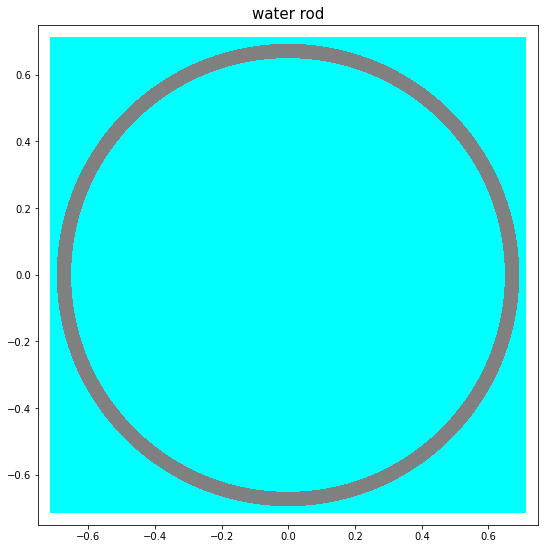

In [113]:
pin_universes[0].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("water rod", fontsize = fs)
plt.show()

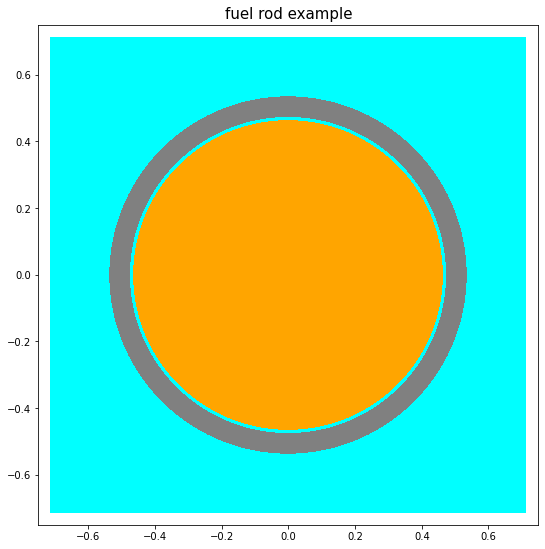

In [114]:
pin_universes[63].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("fuel rod example", fontsize = fs)
plt.show()

## Assembly

In [115]:
# Defining an Assembly

In [116]:
sleave_IL = 23.5
sleave_OL = 26  # I don't actually know this, as it is not clear from the documents.

In [117]:
side_length = pitch * 15
print("Assembly side length =", side_length)

assembly = openmc.RectLattice(name='Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-side_length/2, -side_length/2]

assembly.universes = [
    pin_universes[56:64][::-1] + pin_universes[57:64],  # Top row
    pin_universes[48:56][::-1] + pin_universes[49:56],  # 2nd row
    pin_universes[40:48][::-1] + pin_universes[41:48],  # 3rd row
    pin_universes[32:40][::-1] + pin_universes[33:40],  # 4th row
    pin_universes[24:32][::-1] + pin_universes[25:32],  # 5th row
    pin_universes[16:24][::-1] + pin_universes[17:24],  # 6th row
    pin_universes[8:16][::-1] + pin_universes[9:16],  # 7th row
    pin_universes[0:8][::-1] + pin_universes[1:8],  # Centre row
    pin_universes[8:16][::-1] + pin_universes[9:16],  # 9th row
    pin_universes[16:24][::-1] + pin_universes[17:24],  # 10th row
    pin_universes[24:32][::-1] + pin_universes[25:32],  # 11th row
    pin_universes[32:40][::-1] + pin_universes[33:40],  # 12th row
    pin_universes[40:48][::-1] + pin_universes[41:48],  # 13rd row
    pin_universes[48:56][::-1] + pin_universes[49:56],  # 14nd row
    pin_universes[56:64][::-1] + pin_universes[57:64],  # Bottom row
]
print([len(row) for row in assembly.universes])

assembly_region = openmc.rectangular_prism(width=side_length, height=side_length, 
                                           origin=(0,0))
assembly_cell = openmc.Cell(name='Assembly cell', fill=assembly, region=assembly_region)

assembly_water = openmc.Cell(name='Assembly water')
assembly_water.region = ~assembly_cell.region & openmc.rectangular_prism(width=sleave_IL, 
                                                                         height=sleave_IL,
                                                                         boundary_type='reflective')
assembly_water.fill = water

# assembly_sleave = openmc.Cell(name='Assembly sleave')
# assembly_sleave.region = ~assembly_cell.region & ~assembly_water.region & openmc.rectangular_prism(width=sleave_OL, height=sleave_OL)
# assembly_sleave.fill = zircaloy


assembly_universe = openmc.Universe(cells=[assembly_cell, 
                                           assembly_water,
#                                            assembly_sleave,
                                          ])

Assembly side length = 21.45
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


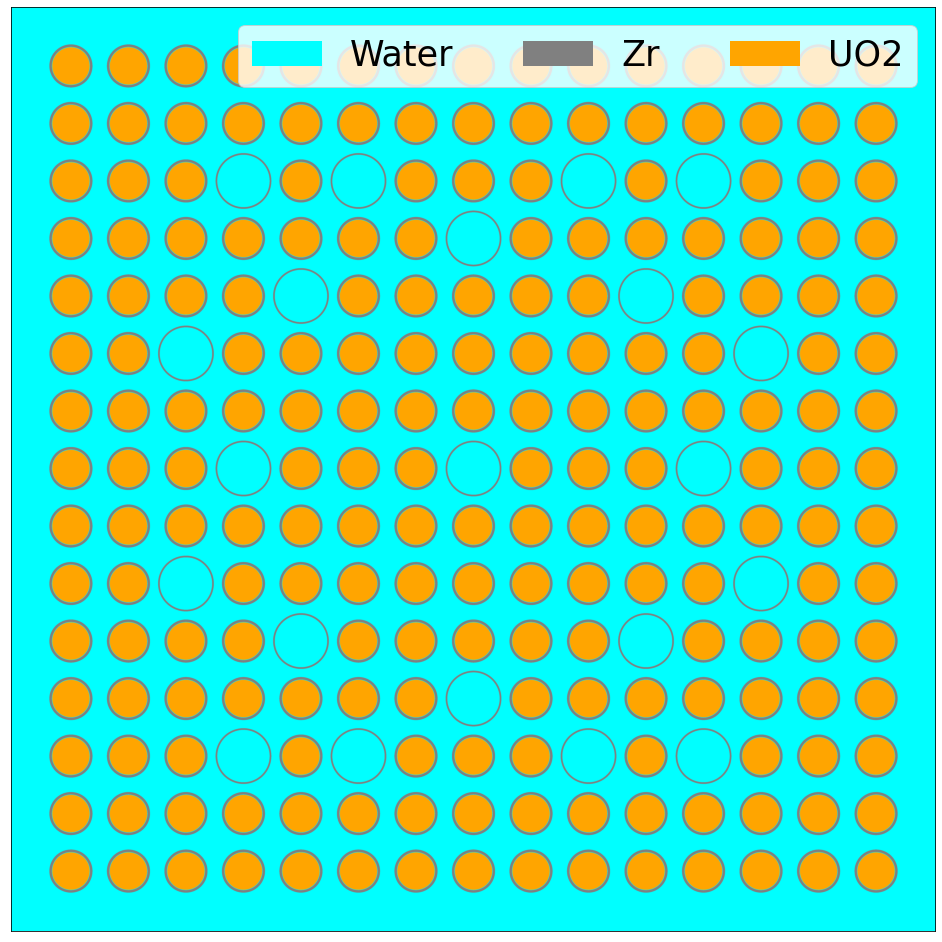

In [118]:
fig, ax = plt.subplots(figsize = (17,17))
assembly_universe.plot(width=(23,23),color_by = "material", 
                       colors = color_dict, axes = ax, pixels = [8000,8000])

ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in ['aqua', 'grey', 'orange']],
          [mat for mat in ['Water', 'Zr', 'UO2']][:3], fontsize = 35, ncols = 3)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig("plots/R2.pdf", format = 'pdf', bbox_inches='tight')
plt.show()

# R3

## 81 different materials for rods

In [83]:
water_idxs = [0, 3, 6, 27, 30, 33, 50, 54, 57]

# Test water-rod placement
for i in range(9):
    print([1 if not (i*9+j in water_idxs) else 2 for j in range(9)])

[2, 1, 1, 2, 1, 1, 2, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 1, 1, 2, 1, 1, 2, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 2, 1, 1, 1]
[2, 1, 1, 2, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]


In [84]:
# This should be changed to read the 64 rod materials from CASMO. In this example it's just fresh UO2 fuel.
def get_fuel_material():
    '''
    IC is a dataframe that contains a column for each pin, and a row for each isotopes.
    Each cell contains the weight percent of that element in this pin.
    Furthermore, it contains an extra column in front with isotope names e.g. U235
    and an extra row at the bottom with the material density in g/cm3.
    i is the fuel-pin index, an int in [0,63]
    '''
    
    if i in water_idxs:
        print("You have given me en i=", i, "that is a water rod.")
        return 0
            
    local_mat = openmc.Material(name='fuel material number' + str(i))
    local_mat.set_density('g/cm3', 10.205)  # Fresh fuel density, from my CASMO file.
    local_mat.add_element('U', 1.0, enrichment=3.095)
    local_mat.add_element('O', 2.0)
    
    # Adding volume is necessary for depletion calculations.
    # Every pin_cell has same volume
    local_mat.volume = np.pi * 0.4645**2  # In cm2.
    
    return local_mat

materials = [get_fuel_material() if not (i in water_idxs) else "water" for i in range(81)]
fuel_materials = [mat for mat in materials if mat != "water" ]

## Materials file

In [85]:
# Instantiate a Materials collection and export to xml. (water only needs to be instantiated once)
materials_file = openmc.Materials(fuel_materials +
                                  [zircaloy, helium, water])
materials_file.export_to_xml()

### Colours for plots:

In [87]:
color_dict = {water: "aqua", zircaloy: "grey", helium: "cyan", steel: "black"}
color_dict.update({mat: "orange" for mat in fuel_materials})

## Geometry

In [59]:
# Geometry definitions

In [89]:
pitch = 1.26
pin_cell_box = openmc.rectangular_prism(width=pitch, height=pitch)

## Water rods

In [90]:
# Geometry definitions for the water rod

water_or = openmc.ZCylinder(r=0.5714)
wclad_or = openmc.ZCylinder(r=0.612)

wwater_inner_region = -water_or
wclad_region = -wclad_or & +water_or 
wwater_outer_region = pin_cell_box & +wclad_or

wwater_inner_cell = openmc.Cell(name='wwater_inner')
wwater_inner_cell.region = wwater_inner_region
wwater_inner_cell.fill = water

wclad_cell = openmc.Cell(name='wclad')
wclad_cell.fill = zircaloy
wclad_cell.region = wclad_region 

wwater_outer_cell = openmc.Cell(name='wwater_outer')
wwater_outer_cell.fill = water
wwater_outer_cell.region = wwater_outer_region

water_pin_universe = openmc.Universe(cells=[wwater_inner_cell, wclad_cell, wwater_outer_cell])

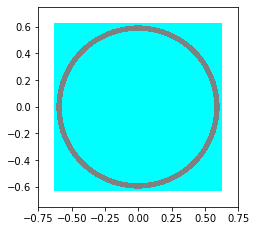

In [91]:
water_pin_universe.plot(width=(1.5, 1.5), color_by = "material", 
                           colors = color_dict)

## 64 different fuel rods

In [92]:
def get_fuel_universe(material):
    fuel_or  = openmc.ZCylinder(r=0.40955, name='Fuel OR')
    fclad_ir = openmc.ZCylinder(r=0.4179, name='Clad IR')
    fclad_or = openmc.ZCylinder(r=0.4750, name='Clad OR')

    fuel_region = -fuel_or 
    gap_region  = +fuel_or & -fclad_ir
    fclad_region  = +fclad_ir & -fclad_or
    fwater_region = pin_cell_box & +fclad_or

    gap_cell = openmc.Cell(name='air gap')
    gap_cell.fill = helium
    gap_cell.region = gap_region

    clad_cell = openmc.Cell(name='clad')
    clad_cell.fill = zircaloy
    clad_cell.region = fclad_region

    fwater_cell = openmc.Cell(name='fwater')
    fwater_cell.fill = water
    fwater_cell.region = fwater_region

    fuel_cell = openmc.Cell(name='fuel')
    fuel_cell.fill = material
    fuel_cell.region = fuel_region 
    local_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])
    return local_universe

# fuel_pin_universe = openmc.Universe(cells=[fuel_cell, gap_cell, clad_cell, fwater_cell])

pin_universes = [water_pin_universe if mat == "water" else get_fuel_universe(mat) for mat in materials]


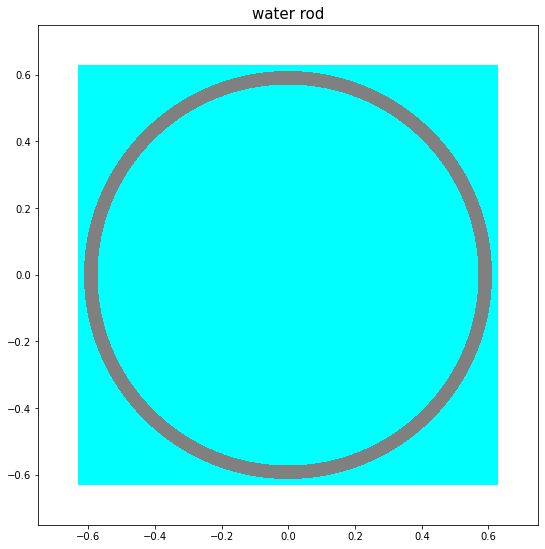

In [93]:
pin_universes[0].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("water rod", fontsize = fs)
plt.show()

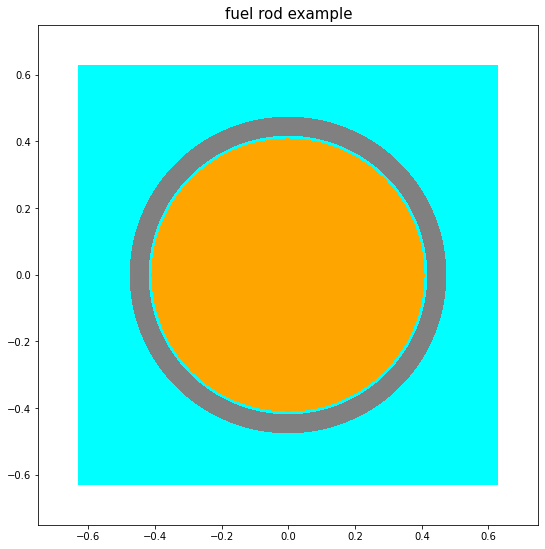

In [94]:
pin_universes[63].plot(width=(1.5, 1.5),color_by = "material", 
                           colors = color_dict, pixels = [500,500])
plt.title("fuel rod example", fontsize = fs)
plt.show()

## Assembly

In [95]:
# Defining an Assembly

In [96]:
sleave_IL = 23.5
sleave_OL = 26  # I don't actually know this, as it is not clear from the documents.

In [98]:
side_length = pitch * 17
print("Assembly side length =", side_length)

assembly = openmc.RectLattice(name='Assembly')
assembly.pitch = (pitch, pitch)
assembly.lower_left = [-side_length/2, -side_length/2]

assembly.universes = [
    pin_universes[72:81][::-1] + pin_universes[73:81],  # Top row
    pin_universes[63:72][::-1] + pin_universes[64:72],  # 2nd row
    pin_universes[54:63][::-1] + pin_universes[55:63],  # 3rd row
    pin_universes[45:54][::-1] + pin_universes[46:54],  # 4th row
    pin_universes[36:45][::-1] + pin_universes[37:45],  # 5th row
    pin_universes[27:36][::-1] + pin_universes[28:36],  # 6th row
    pin_universes[18:27][::-1] + pin_universes[19:27],  # 7th row
    pin_universes[9:18][::-1] + pin_universes[10:18],  # 8th row
    pin_universes[0:9][::-1] + pin_universes[1:9],  # Centre row
    pin_universes[9:18][::-1] + pin_universes[10:18],  # 10th row
    pin_universes[18:27][::-1] + pin_universes[19:27],  # 11th row
    pin_universes[27:36][::-1] + pin_universes[28:36],  # 12th row
    pin_universes[36:45][::-1] + pin_universes[37:45],  # 13th row
    pin_universes[45:54][::-1] + pin_universes[46:54],  # 14th row
    pin_universes[54:63][::-1] + pin_universes[55:63],  # 15th row
    pin_universes[63:72][::-1] + pin_universes[64:72],  # 16th row
    pin_universes[72:81][::-1] + pin_universes[73:81],  # Bottom arow
]
print([len(row) for row in assembly.universes])

assembly_region = openmc.rectangular_prism(width=side_length, height=side_length, 
                                           origin=(0,0))
assembly_cell = openmc.Cell(name='Assembly cell', fill=assembly, region=assembly_region)

assembly_water = openmc.Cell(name='Assembly water')
assembly_water.region = ~assembly_cell.region & openmc.rectangular_prism(width=sleave_IL, 
                                                                         height=sleave_IL,
                                                                         boundary_type='reflective')
assembly_water.fill = water

# assembly_sleave = openmc.Cell(name='Assembly sleave')
# assembly_sleave.region = ~assembly_cell.region & ~assembly_water.region & openmc.rectangular_prism(width=sleave_OL, height=sleave_OL)
# assembly_sleave.fill = zircaloy


assembly_universe = openmc.Universe(cells=[assembly_cell, 
                                           assembly_water,
#                                            assembly_sleave,
                                          ])

Assembly side length = 21.42
[17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


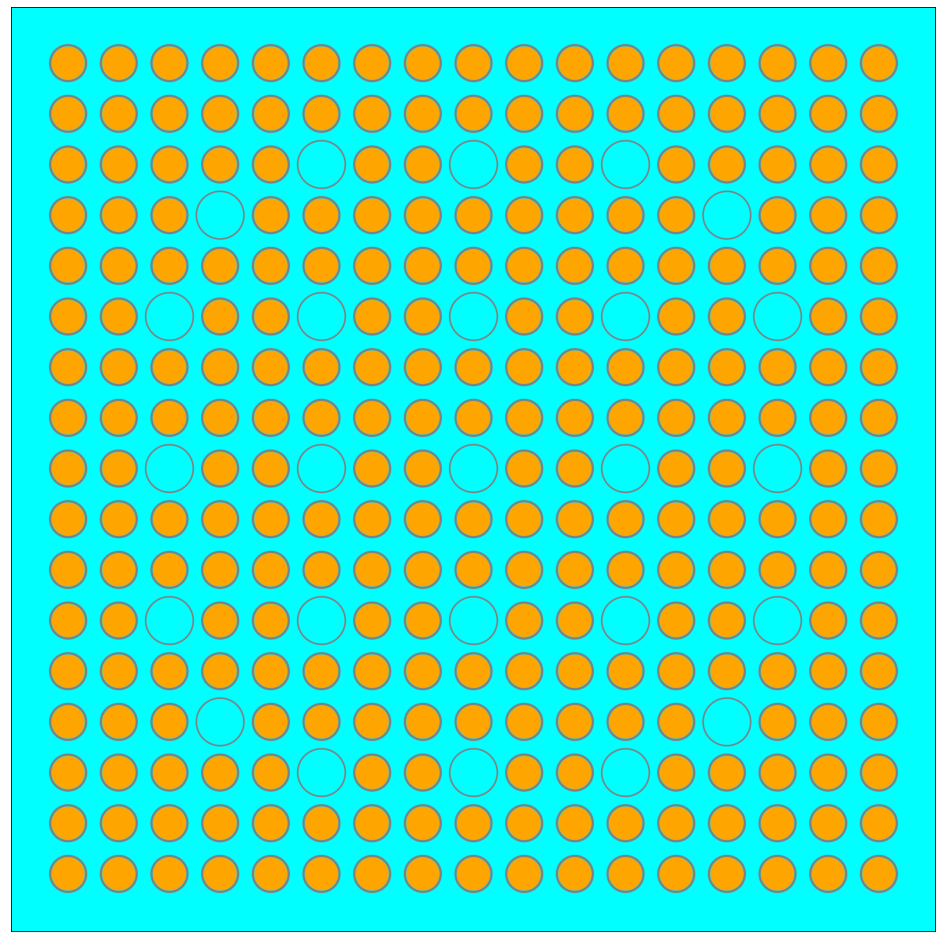

In [101]:
fig, ax = plt.subplots(figsize = (17,17))
assembly_universe.plot(width=(23,23),color_by = "material", 
                       colors = color_dict, axes = ax, pixels = [8000,8000])

# ax.legend([plt.Rectangle((0, 0), 1, 1, fc=col) for col in ['aqua', 'grey', 'orange']],
#           [mat for mat in ['Water', 'Zircaloy', 'UO2']][:3], fontsize = 35, ncols = 3)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig("plots/R3.pdf", format = 'pdf', bbox_inches='tight')
plt.show()